In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import ast
import seaborn as sns

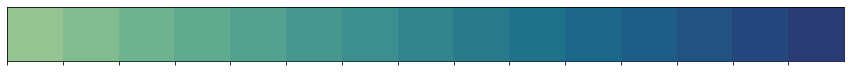

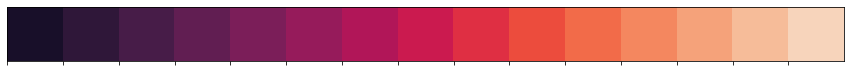

In [2]:
#DEFINIMOS PALETA DE COLOR AESTHETIC DE AZULES
cold_palette = sns.color_palette('crest', 15)
sns.palplot(cold_palette) 
hot_palette = sns.color_palette('rocket', 15) 
sns.palplot(hot_palette)

In [3]:
#funcion para extraer el lema (forma singular y masculina) del noun
def obtener_forma_singular(palabra):
    lematizador = WordNetLemmatizer()
    lema = lematizador.lemmatize(palabra,'n')
    return lema

In [4]:
def CargoListas(language, cota, datadir, desde, hasta):
        words = []
        d = os.listdir(datadir) #por como guardo mis datos no hace falta usar language
        for filename in tqdm(d):
            if filename.startswith('lista_NOUN'):
                print(f'Open file {filename}',end="")
                with open(os.path.join(datadir, filename), 'r', encoding='utf-8') as file:
                    for line in file:
                        parts = line.strip().split('\t')
                        wordorig = parts[0]
                        #print(wordorig)
                        word = wordorig.replace('_NOUN', '').lower()
                        #print(word)
                        years, n1s, n2s = [],[],[]
                        for texto in parts[1:]:
                            year,n1,n2 = texto.split(',')
                            years.append(int(year))
                            n1s.append(int(n1))
                            n2s.append(int(n2))
                            # print(word,year,n1,n2)
                        cond = [desde <= year <= hasta for year in years]
                        years = [year for i, year in enumerate(years) if cond[i]]
                        #print(len(years))
                        samples = [n1 for i, n1 in enumerate(n1s) if cond[i]]
                        total = np.abs(np.sum(n1s))
                        #print(total)
                        if total>=cota and len(word)>2 and len(years)==(hasta-desde+1) and word[0] in 'abcdefghijklmnñopqrstuvwxyz' and '.' not in word:
                            words.append({ 
                                'word': word,
                                'wordorig': wordorig,
                                'years': years,
                                'samples': samples,
                                'total': total
                            })
                print('  ',len(words))
            #if filename == "lista_NOUN_09.txt": #aca digo hasta cual carga
                #break
        words = pd.DataFrame(words)
        print(f'Me quedan {len(words)} palabras despues de cargar todo')
        return words
    

        
def SacoChirimbolos(data, language):
        chirimbolos = set()
        if language in ['en2020', 'ae2020', 'be2020', 'en2012', 'ae2012', 'be2012', 'fe2020']:
            chirimbolos = set(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '\'', 'æ', 'é', '.', '*', '+', '/', '%', '★','™','δ','→','á', ':', '@', '=', '<', '>'])
        elif language in ['es2020', 'es2012', 'al2020']:
            chirimbolos = set(['.'])
        elif language == 'it2020':
            chirimbolos = set(['.', '\'', '-'])
        elif language == 'fr2020':
            chirimbolos = set(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'œ'])    
        data_sc = data[data['word'].apply(lambda word: not any(char in chirimbolos for char in word))]
        print(f'Me quedan {len(data_sc)} palabras despues de sacar chirimbolos')
        data_sc = data_sc.reset_index()
        return data_sc
    
    
#me quedo con palabras que aparecen todos los años desde 1700    
def filter_all_years(data, From, To):
    index = To - From 
    condition = np.arange(From, To+1, 1)
    index_to_drop = set()
    
    data['years']=data['years'].str[-index-1:]
    data['samples']=data['samples'].str[-index-1:]
    #np where busco indice del primer año mayor o igual a 1700 y me quedo con esos
    
    for row in range(len(data.loc[:,'years'])):
        if len(data.loc[row,'years'])<len(condition): #or data.loc[row,'years'][0] != From:
            index_to_drop.add(row) ####mal
  
    data = data.drop(index_to_drop).reset_index(drop=True)
    return(data)

def colapso_mayusculas(data):
        data['word']=data['word'].str.lower()
        new_df= data.groupby('word').agg({'wordorig': ' '.join, 'samples': lambda x: [sum(i) for i in zip(*x)]}).reset_index()
        print('Me quedan {} palabras después de colapsar mayusculas.'.format(len(new_df)))
        return new_df
    
def colapso_plurales(data):  
        data['word_lemma'] = data['word'].apply(obtener_forma_singular) #creo una nueva columna con los lemas
        new_df= data.groupby('word_lemma').agg({'wordorig': ' '.join, 'samples': lambda x: [sum(i) for i in zip(*x)]}).reset_index()
        print('Me quedan {} palabras después de colapsar las variaciones.'.format(len(new_df)))
        return new_df
    
    


In [5]:
#Cargo datos
language = 'en2020'
datadir = f'C:/Users/Zoe/Desktop/Proyecto nouns/{language}/raw/'
desdeLong = 1700
desdeShort = 1750
hastaShort = 2000
hastaLong = 2019
cota=1e6
years = np.arange(desdeLong, hastaLong+1)

In [6]:
data=CargoListas(language,cota,datadir, desdeShort, hastaLong)

  0%|          | 0/24 [00:00<?, ?it/s]

Open file lista_NOUN_01.txt

  4%|▍         | 1/24 [00:04<01:36,  4.18s/it]

   0
Open file lista_NOUN_02.txt

  8%|▊         | 2/24 [00:08<01:35,  4.34s/it]

   0
Open file lista_NOUN_03.txt

 12%|█▎        | 3/24 [00:14<01:44,  4.96s/it]

   0
Open file lista_NOUN_04.txt

 17%|█▋        | 4/24 [00:19<01:38,  4.95s/it]

   0
Open file lista_NOUN_05.txt

 21%|██        | 5/24 [00:25<01:42,  5.41s/it]

   0
Open file lista_NOUN_06.txt

 25%|██▌       | 6/24 [00:31<01:43,  5.73s/it]

   0
Open file lista_NOUN_07.txt

 29%|██▉       | 7/24 [01:21<05:41, 20.11s/it]

   443
Open file lista_NOUN_08.txt

 33%|███▎      | 8/24 [02:59<11:56, 44.77s/it]

   1319
Open file lista_NOUN_09.txt

 38%|███▊      | 9/24 [04:37<15:22, 61.51s/it]

   2525
Open file lista_NOUN_10.txt

 42%|████▏     | 10/24 [06:13<16:49, 72.14s/it]

   3367
Open file lista_NOUN_11.txt

 46%|████▌     | 11/24 [08:57<21:42, 100.17s/it]

   4133
Open file lista_NOUN_12.txt

 50%|█████     | 12/24 [12:35<27:14, 136.24s/it]

   4969
Open file lista_NOUN_13.txt

 54%|█████▍    | 13/24 [15:05<25:43, 140.33s/it]

   5646
Open file lista_NOUN_14.txt

 58%|█████▊    | 14/24 [17:48<24:32, 147.24s/it]

   6600
Open file lista_NOUN_15.txt

 62%|██████▎   | 15/24 [21:00<24:06, 160.70s/it]

   7600
Open file lista_NOUN_16.txt

 67%|██████▋   | 16/24 [23:54<21:56, 164.56s/it]

   8241
Open file lista_NOUN_17.txt

 71%|███████   | 17/24 [25:59<17:49, 152.82s/it]

   9600
Open file lista_NOUN_18.txt

 75%|███████▌  | 18/24 [27:48<13:57, 139.58s/it]

   11253
Open file lista_NOUN_19.txt

 79%|███████▉  | 19/24 [29:20<10:27, 125.43s/it]

   12540
Open file lista_NOUN_20.txt

 83%|████████▎ | 20/24 [31:04<07:54, 118.74s/it]

   13533
Open file lista_NOUN_21.txt

 88%|████████▊ | 21/24 [42:14<14:13, 284.46s/it]

   14530
Open file lista_NOUN_22.txt

 92%|█████████▏| 22/24 [43:13<07:13, 216.64s/it]

   15735
Open file lista_NOUN_23.txt

 96%|█████████▌| 23/24 [44:20<02:51, 171.69s/it]

   17325
Open file lista_NOUN_24.txt

100%|██████████| 24/24 [45:28<00:00, 113.68s/it]

   18436
Me quedan 18436 palabras despues de cargar todo


In [7]:
#tiempo_dir=f'C:/Users/Zoe/Desktop/Proyecto nouns/{language}/raw'
#tiempo=CargoListas(language,cota,tiempo_dir, desdeShort, hastaLong)


In [8]:
#chequeo
var='time'
palabra=data.query('word==@var')
print(palabra)

       word   wordorig                                              years  \
6956   time  TIME_NOUN  [1750, 1751, 1752, 1753, 1754, 1755, 1756, 175...   
7025   time  Time_NOUN  [1750, 1751, 1752, 1753, 1754, 1755, 1756, 175...   
17483  time  time_NOUN  [1750, 1751, 1752, 1753, 1754, 1755, 1756, 175...   

                                                 samples       total  
6956   [18, 27, 10, 22, 17, 4, 24, 16, 32, 33, 65, 17...    14933012  
7025   [21072, 26215, 17053, 22273, 11365, 15606, 799...    88310516  
17483  [26446, 27730, 25149, 35860, 42643, 32929, 285...  2078362215  


In [9]:
data_sin_chirimbolos=SacoChirimbolos(data,language)
print(data_sin_chirimbolos)

#data_filtrada = filter_all_years(data_sin_chirimbolos, desdeLong, hastaLong)

#data_filtrada['word_lemma'] = data_filtrada['word'].apply(obtener_forma_singular) #creo una nueva columna con los lemas

#print(data_filtrada[100:])
#var='Ally'+'_NOUN'
#palabra=data_filtrada.query('wordorig==@var')
#print(palabra['samples'])

Me quedan 18434 palabras despues de sacar chirimbolos
       index        word         wordorig  \
0          0  advantages  Advantages_NOUN   
1          1       alice       Alice_NOUN   
2          2     address     Address_NOUN   
3          3  acceptance  Acceptance_NOUN   
4          4      arrest      Arrest_NOUN   
...      ...         ...              ...   
18429  18431       trick       trick_NOUN   
18430  18432       wasps       wasps_NOUN   
18431  18433      wrists      wrists_NOUN   
18432  18434    theories    theories_NOUN   
18433  18435    vivacity    vivacity_NOUN   

                                                   years  \
0      [1750, 1751, 1752, 1753, 1754, 1755, 1756, 175...   
1      [1750, 1751, 1752, 1753, 1754, 1755, 1756, 175...   
2      [1750, 1751, 1752, 1753, 1754, 1755, 1756, 175...   
3      [1750, 1751, 1752, 1753, 1754, 1755, 1756, 175...   
4      [1750, 1751, 1752, 1753, 1754, 1755, 1756, 175...   
...                                          

In [10]:
data_minuscula = colapso_mayusculas(data_sin_chirimbolos)
data_singular=colapso_plurales(data_minuscula)



Me quedan 13579 palabras después de colapsar mayusculas.
Me quedan 10431 palabras después de colapsar las variaciones.


In [11]:
#chequeo
var='body'
palabra=data_minuscula.query('word==@var')
print(palabra)

      word                       wordorig  \
1349  body  Body_NOUN BODY_NOUN body_NOUN   

                                                samples word_lemma  
1349  [17477, 15868, 13376, 19556, 17503, 13958, 125...       body  


In [12]:
prueba=f'C:/Users/Zoe/Desktop/Proyecto nouns/{language}/intento_1.csv'
data_singular.to_csv(prueba, sep=';', index=False)

In [13]:
years_totales=[]
samples_totales=[]
txt_file=f'C:/Users/Zoe/Desktop/Proyecto nouns/{language}/Totales_en2020.txt'

with open(txt_file, 'r') as file:
    for line in file:
        # Split the line into columns (assuming they are separated by spaces)
        columns = line.strip().split(',')
        years,samples,pages,books = line.strip().split(',')
        years_totales.append(int(years))
        samples_totales.append(int(samples))

years_totales = np.array(years_totales)
samples_totales = np.array(samples_totales)  
condition = np.where(years_totales>=desdeShort)[0]

years_totales = years_totales[condition]
samples_totales = samples_totales[condition]
    
years = np.arange(desdeShort, hastaLong+1)

years_value = np.isin(years, years_totales)
false_positions = np.where(years_value == False)[0]

#print('false positions',false_positions)

#Agrego 0s si hace falta 
for i in false_positions:
    years_totales = years 
    samples_totales = np.insert(samples_totales, i,0)
    
print(len(years))


270


In [14]:
df = pd.read_csv(f'C:/Users/Zoe/Desktop/Proyecto nouns/{language}/intento_1.csv',sep=';')
df['samples']=df['samples'].apply(ast.literal_eval)

     word_lemma                                           wordorig  \
1063       body  Bodies_NOUN bodies_NOUN Body_NOUN BODY_NOUN bo...   

                                                samples  
1063  [23199, 20132, 16376, 24880, 22636, 17839, 164...  
[list([23199, 20132, 16376, 24880, 22636, 17839, 16442, 16266, 21135, 24461, 23253, 22196, 17475, 22127, 26417, 24513, 21694, 25252, 28774, 21285, 24245, 28686, 25735, 25223, 25887, 29624, 25031, 25194, 22641, 23877, 24657, 25091, 27760, 25424, 33975, 33688, 32246, 33635, 38375, 32507, 45307, 46024, 53229, 52518, 58805, 53227, 56330, 57345, 68254, 63042, 102140, 99857, 100899, 135525, 133695, 136815, 166735, 194147, 204048, 267348, 279613, 225868, 284696, 267620, 216805, 244020, 270145, 271942, 291196, 309444, 297516, 282518, 387403, 405327, 437936, 444063, 409228, 412104, 450238, 515087, 551485, 530473, 663115, 593304, 591095, 669706, 696315, 653132, 635060, 750087, 689529, 696033, 734430, 714020, 802058, 934423, 775117, 797472, 802

C:\Users\Zoe\AppData\Local\Temp\ipykernel_11624\1205040927.py:17: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  body_samps = pd.read_csv(f'C:/Users/Zoe/Desktop/Proyecto nouns/{language}/body.csv',sep='\r\n')


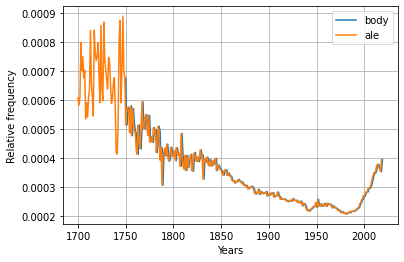

In [15]:
# Defino cuál quiero
var='body'
palabra=data_singular.query('word_lemma==@var')
print(palabra)

word_samples = np.array(palabra['samples'])
print(word_samples)
word_norm=word_samples[0]/samples_totales


plt.plot(years, word_norm, label=var)




#ale
body_samps = pd.read_csv(f'C:/Users/Zoe/Desktop/Proyecto nouns/{language}/body.csv',sep='\r\n')
body_samps = np.array(body_samps).flatten().flatten()
body_samps_str = np.array(', '.join(map(str, body_samps)))

print(body_samps_str)

plt.plot(np.arange(desdeLong, hastaLong), body_samps, label='ale')



plt.ylabel('Relative frequency')
plt.xlabel('Years')
plt.legend()
plt.grid()
plt.show()


     word_lemma                     wordorig  \
1664   chemical  Chemical_NOUN chemical_NOUN   

                                                samples  
1664  [49, 206, 52, 267, 257, 102, 199, 136, 112, 14...  
8.0585e-06, 1.0064e-06, 1.0008e-06, 1.13e-05, 2.5169e-07, 4.6373e-07, 4.2443e-07, 1.4103e-06, 2.5584e-06, 1.7013e-07, 4.0513e-07, 4.2088e-07, 6.0253e-06, 7.4631e-07, 3.8022e-07, 2.2718e-07, 2.1239e-05, 2.3777e-07, 3.0992e-07, 5.349e-07, 3.2515e-07, 2.3047e-07, 5.0742e-07, 1.349e-06, 6.2207e-06, 2.5936e-07, 2.0548e-07, 6.1765e-07, 8.8978e-06, 5.6042e-06, 8.9807e-06, 3.0331e-06, 3.5515e-06, 2.0482e-06, 6.1772e-06, 6.0975e-06, 1.8789e-06, 1.3128e-06, 8.489e-07, 9.2058e-07, 9.5722e-06, 9.2727e-07, 2.3585e-06, 8.0684e-06, 2.3303e-05, 5.5284e-06, 1.7499e-06, 2.4741e-06, 2.5786e-06, 1.4266e-06, 5.2485e-06, 1.8037e-06, 6.1653e-06, 6.4209e-06, 2.7836e-06, 7.0059e-06, 3.9832e-06, 3.021e-06, 3.081e-06, 2.2595e-06, 3.5893e-06, 2.3134e-06, 1.9747e-06, 7.9076e-06, 6.6474e-06, 2.464e-06, 5.6

C:\Users\Zoe\AppData\Local\Temp\ipykernel_11624\3840546612.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  chem_samps = pd.read_csv(f'C:/Users/Zoe/Desktop/Proyecto nouns/{language}/chemical.csv',sep='\r\n')


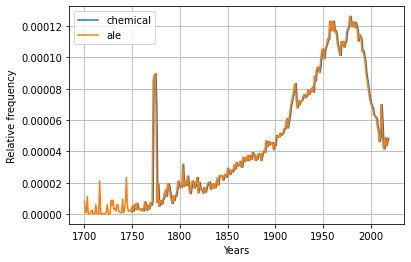

In [16]:
# Defino cuál quiero
var='chemical'
palabra=data_singular.query('word_lemma==@var')
print(palabra)

word_samples = np.array(palabra['samples'])
word_norm=word_samples[0]/samples_totales   


plt.plot(years, word_norm, label=var)


#ale
chem_samps = pd.read_csv(f'C:/Users/Zoe/Desktop/Proyecto nouns/{language}/chemical.csv',sep='\r\n')
chem_samps = np.array(chem_samps).flatten().flatten()
chem_samps_str = np.array(', '.join(map(str, chem_samps)))

print(chem_samps_str)
plt.plot(np.arange(desdeLong, hastaLong), chem_samps, label='ale')


plt.ylabel('Relative frequency')
plt.xlabel('Years')
plt.grid()
plt.legend()
plt.show()

     word_lemma                                           wordorig  \
9487       time  TIME_NOUN Time_NOUN time_NOUN Times_NOUN times...   

                                                samples  
9487  [57298, 65123, 50039, 69990, 64111, 58283, 440...  
[list([57298, 65123, 50039, 69990, 64111, 58283, 44013, 57988, 61325, 81069, 80285, 82957, 74553, 96380, 97150, 103179, 92857, 91077, 83540, 65598, 77050, 93093, 75369, 77648, 90114, 94868, 93218, 83367, 83949, 83422, 84346, 86439, 90017, 101172, 128049, 108275, 108795, 143359, 145937, 153491, 172704, 162602, 190505, 204533, 208205, 202585, 208385, 229258, 254997, 236591, 391439, 373248, 351074, 582948, 454414, 511031, 615660, 697037, 837441, 870775, 1023172, 933590, 1251378, 1017028, 932042, 908162, 1193111, 1049537, 1103007, 1116949, 1273799, 1225864, 1389869, 1481367, 1639158, 1709716, 1545480, 1586379, 1683226, 1809222, 2047436, 1919912, 3141697, 2232141, 2317848, 2493647, 2625219, 2629549, 2595107, 2884697, 2777478, 2825722, 284

0.0015256, 0.001834, 0.0015968, 0.0015538, 0.0016463, 0.0014702, 0.0017137, 0.0016709, 0.0014571, 0.0014733, 0.0016635, 0.0016234, 0.0014524, 0.0013851, 0.0017315, 0.0015542, 0.0015989, 0.001491, 0.0015229, 0.0015609, 0.0017252, 0.0014835, 0.0016933, 0.0017139, 0.0016244, 0.0017567, 0.0016088, 0.0017811, 0.001697, 0.0019303, 0.0017811, 0.0015826, 0.0017073, 0.0018791, 0.0016403, 0.001746, 0.001575, 0.0016551, 0.0018312, 0.0016008, 0.0017245, 0.0019087, 0.0016669, 0.0016677, 0.0016343, 0.0014757, 0.0017378, 0.0017056, 0.001514, 0.0016682, 0.0016592, 0.0017357, 0.0016161, 0.0016017, 0.0015906, 0.0015495, 0.0016984, 0.0016541, 0.0017226, 0.0017113, 0.0018046, 0.0018155, 0.0017955, 0.0018875, 0.0019375, 0.0018451, 0.0017919, 0.0017236, 0.0015617, 0.0015881, 0.0017479, 0.0016072, 0.001567, 0.0016607, 0.0017506, 0.0016934, 0.0015596, 0.0016975, 0.0015839, 0.0017229, 0.0016828, 0.0016142, 0.0016637, 0.0017143, 0.0016357, 0.0016561, 0.0016703, 0.001653, 0.0014399, 0.0015585, 0.0014871, 0.00155

C:\Users\Zoe\AppData\Local\Temp\ipykernel_11624\3038809976.py:15: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  time_samps = pd.read_csv(f'C:/Users/Zoe/Desktop/Proyecto nouns/{language}/time.csv',sep='\r\n')


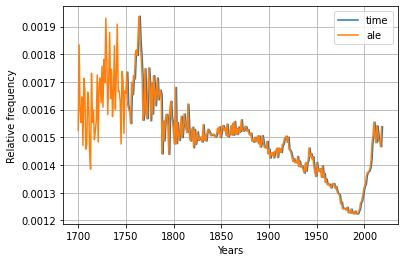

In [17]:
# Defino cuál quiero
var='time'
palabra=data_singular.query('word_lemma==@var')
print(palabra)

word_samples = np.array(palabra['samples'])
print(word_samples)
word_norm=word_samples[0]/samples_totales  


plt.plot(years, word_norm, label=var)


#ale
time_samps = pd.read_csv(f'C:/Users/Zoe/Desktop/Proyecto nouns/{language}/time.csv',sep='\r\n')
time_samps = np.array(time_samps).flatten().flatten()
time_samps_str = np.array(', '.join(map(str, time_samps)))

print(time_samps_str)

plt.plot(np.arange(desdeLong, hastaLong), time_samps, label='ale')

#otro
#time_alt = pd.read_csv(f'C:/Users/Zoe/Desktop/Proyecto nouns/{language}/TIME.txt',sep='\t')
#print('holi',time_alt)

plt.ylabel('Relative frequency')
plt.xlabel('Years')
plt.legend()
plt.grid()
plt.show()

     word_lemma                                           wordorig  \
8316     school  SCHOOL_NOUN School_NOUN school_NOUN Schools_NO...   

                                                samples  
8316  [1471, 2126, 1492, 2785, 2372, 2742, 2060, 135...  
[list([1471, 2126, 1492, 2785, 2372, 2742, 2060, 1352, 1915, 3209, 2614, 2795, 3308, 2788, 3304, 3200, 3343, 2232, 2310, 2915, 2266, 3061, 3259, 3858, 4395, 3547, 3406, 2754, 3010, 3041, 3672, 3336, 3714, 3265, 6381, 4503, 4875, 6061, 5914, 14163, 8172, 9119, 11005, 9955, 10063, 9942, 11964, 10474, 13370, 13291, 70174, 24824, 22019, 24509, 23377, 28197, 36046, 41105, 52282, 50680, 69646, 62912, 78046, 87011, 68202, 68274, 112900, 87699, 137235, 176391, 120554, 117719, 125460, 126863, 155812, 178747, 155884, 172505, 210434, 197398, 206892, 241206, 426836, 285779, 291520, 553788, 351647, 367362, 421903, 459542, 411965, 427909, 452999, 391552, 464178, 500020, 515797, 553226, 487000, 592787, 599542, 730734, 707077, 800482, 978645, 854946

C:\Users\Zoe\AppData\Local\Temp\ipykernel_11624\2035538090.py:17: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  time_samps = pd.read_csv(f'C:/Users/Zoe/Desktop/Proyecto nouns/{language}/school.csv',sep='\r\n')


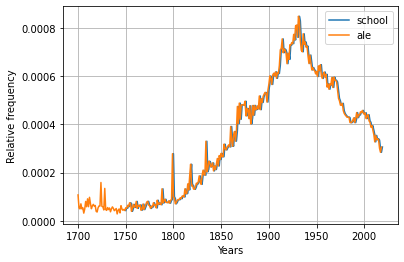

In [18]:
# Defino cuál quiero
var='school'
palabra=data_singular.query('word_lemma==@var')
print(palabra)

word_samples = np.array(palabra['samples'])
print(word_samples)
word_norm=word_samples[0]/samples_totales  


plt.plot(years, word_norm, label=var)




#ale
time_samps = pd.read_csv(f'C:/Users/Zoe/Desktop/Proyecto nouns/{language}/school.csv',sep='\r\n')
time_samps = np.array(time_samps).flatten().flatten()
time_samps_str = np.array(', '.join(map(str, time_samps)))

print(time_samps_str)

plt.plot(np.arange(desdeLong, hastaLong), time_samps, label='ale')



plt.ylabel('Relative frequency')
plt.xlabel('Years')
plt.legend()
plt.grid()
plt.show()

     word_lemma                        wordorig  \
7704       rank  Rank_NOUN rank_NOUN ranks_NOUN   

                                                samples  
7704  [1907, 2040, 1813, 2982, 2366, 2070, 2034, 317...  
[list([1907, 2040, 1813, 2982, 2366, 2070, 2034, 3177, 2793, 4238, 4819, 3584, 3743, 3712, 3327, 2960, 3431, 4361, 3937, 3592, 4248, 4024, 3614, 3581, 4204, 4585, 5407, 6247, 5308, 5770, 5243, 6034, 6148, 6981, 6540, 5655, 6251, 9353, 10317, 9167, 10925, 9976, 12053, 12323, 15155, 17331, 14287, 16418, 17304, 15775, 22896, 23630, 24162, 32246, 33609, 39677, 43119, 46481, 45891, 51532, 61412, 59425, 76293, 68528, 64228, 60666, 66705, 66854, 72493, 67658, 85330, 80465, 91545, 91990, 101100, 112617, 93718, 115839, 107637, 107668, 127606, 114776, 140784, 135785, 139416, 146334, 147235, 139437, 137321, 147972, 156891, 153536, 147705, 146145, 159102, 180222, 167031, 162635, 163200, 160248, 170247, 186862, 192448, 208803, 227461, 226738, 221034, 199764, 187716, 203360, 215561, 1

C:\Users\Zoe\AppData\Local\Temp\ipykernel_11624\3544159694.py:17: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  time_samps = pd.read_csv(f'C:/Users/Zoe/Desktop/Proyecto nouns/{language}/rank.csv',sep='\r\n')


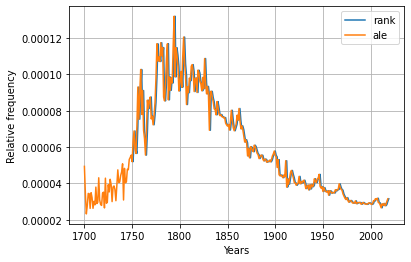

In [19]:
# Defino cuál quiero
var='rank'
palabra=data_singular.query('word_lemma==@var')
print(palabra)

word_samples = np.array(palabra['samples'])
print(word_samples)
word_norm=word_samples[0]/samples_totales  


plt.plot(years, word_norm, label=var)




#ale
time_samps = pd.read_csv(f'C:/Users/Zoe/Desktop/Proyecto nouns/{language}/rank.csv',sep='\r\n')
time_samps = np.array(time_samps).flatten().flatten()
time_samps_str = np.array(', '.join(map(str, time_samps)))

print(time_samps_str)

plt.plot(np.arange(desdeLong, hastaLong), time_samps, label='ale')



plt.ylabel('Relative frequency')
plt.xlabel('Years')
plt.legend()
plt.grid()
plt.show()

Ahora voy a construir una función que tome una palabra y la grafique. Además, que calcule el LGR (r)

In [55]:
def log_growth_rate(data, chosen_word, N, years,dt=1):
    word=data.query('word_lemma==@chosen_word')
    print(word)
    u = np.array(word['samples'])
    f=u[0]/N   


    plt.plot(years, f, label=chosen_word)
    plt.ylabel('Relative frequency')
    plt.xlabel('Years')
    plt.grid()
    plt.legend()
    plt.show()
    
    r=np.array([])
    for i in range(len(years)-dt):
        r_i=np.log(f[i+dt])-np.log(f[i])
        r=np.append(r,r_i)

    plt.plot(years[:-dt], r, label=chosen_word)
    plt.ylabel('Log growth rate')
    plt.xlabel(f'Years (with dt={dt})')
    plt.grid()
    plt.legend()
    plt.show()
    
    
    f_m = np.array([])
    for i in range(len(years)):
        f_m_i = np.median(f[i])
        f_m=np.append(f_m,f_m_i) #tira de f_m por años (len=270)

    #f es la tira de f_i
    
    #calculo birth year y death year
    
    for j in range(len(years)):
        if f[j]>= 0.05*f_m[j]: #0.05 threshold
            y_0=years[j]
            break 
        
    for j in reversed(range(len(years))):
        if f[j]>= 0.05*f_m[j]: #0.05 threshold
            y_f=years[j]
            break 
    

    return np.array([y_0, y_f])

     word_lemma                                           wordorig  \
9487       time  TIME_NOUN Time_NOUN time_NOUN Times_NOUN times...   

                                                samples  
9487  [57298, 65123, 50039, 69990, 64111, 58283, 440...  


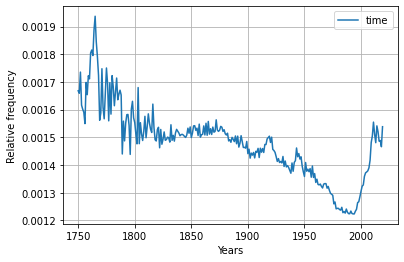

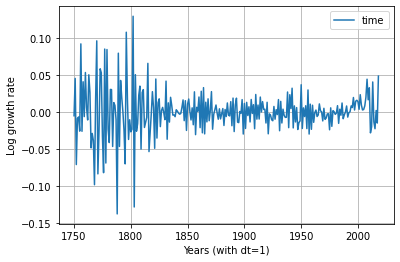

1750 2019


In [37]:
years = np.arange(desdeShort, hastaLong+1)
log_growth_rate(data_singular, 'time', samples_totales, years)

Vocab Growth
Lifetime growth
P, sigma
Autocorrelation

  0%|          | 0/10431 [00:00<?, ?it/s]

      word_lemma                                   wordorig  \
0          aaron                                 Aaron_NOUN   
1        abandon                               abandon_NOUN   
2      abatement              Abatement_NOUN abatement_NOUN   
3           abba                                  Abba_NOUN   
4          abbas                                 Abbas_NOUN   
...          ...                                        ...   
10426       zeno                                  Zeno_NOUN   
10427       zion                                  Zion_NOUN   
10428       zone  Zone_NOUN zone_NOUN Zones_NOUN zones_NOUN   
10429        zoo                                   zoo_NOUN   
10430     zurich                                Zurich_NOUN   

                                                 samples  
0      [217, 148, 102, 234, 234, 379, 492, 149, 444, ...  
1      [11, 13, 7, 15, 33, 12, 9, 4, 18, 12, 19, 12, ...  
2      [267, 436, 123, 164, 189, 210, 125, 252, 136, ...  
3      

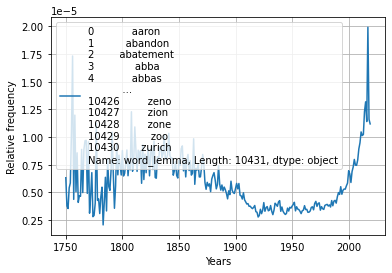

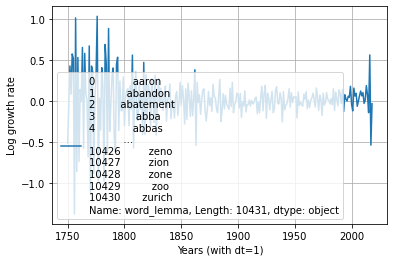

  0%|          | 1/10431 [00:01<3:18:19,  1.14s/it]

      word_lemma                                   wordorig  \
0          aaron                                 Aaron_NOUN   
1        abandon                               abandon_NOUN   
2      abatement              Abatement_NOUN abatement_NOUN   
3           abba                                  Abba_NOUN   
4          abbas                                 Abbas_NOUN   
...          ...                                        ...   
10426       zeno                                  Zeno_NOUN   
10427       zion                                  Zion_NOUN   
10428       zone  Zone_NOUN zone_NOUN Zones_NOUN zones_NOUN   
10429        zoo                                   zoo_NOUN   
10430     zurich                                Zurich_NOUN   

                                                 samples  
0      [217, 148, 102, 234, 234, 379, 492, 149, 444, ...  
1      [11, 13, 7, 15, 33, 12, 9, 4, 18, 12, 19, 12, ...  
2      [267, 436, 123, 164, 189, 210, 125, 252, 136, ...  
3      

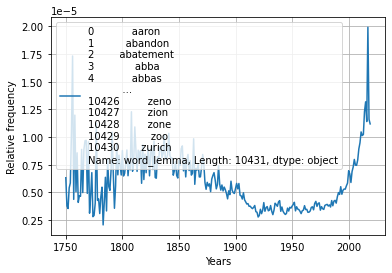

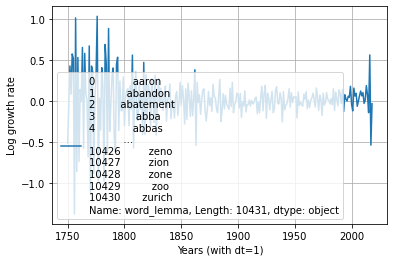

  0%|          | 2/10431 [00:01<2:43:04,  1.07it/s]

      word_lemma                                   wordorig  \
0          aaron                                 Aaron_NOUN   
1        abandon                               abandon_NOUN   
2      abatement              Abatement_NOUN abatement_NOUN   
3           abba                                  Abba_NOUN   
4          abbas                                 Abbas_NOUN   
...          ...                                        ...   
10426       zeno                                  Zeno_NOUN   
10427       zion                                  Zion_NOUN   
10428       zone  Zone_NOUN zone_NOUN Zones_NOUN zones_NOUN   
10429        zoo                                   zoo_NOUN   
10430     zurich                                Zurich_NOUN   

                                                 samples  
0      [217, 148, 102, 234, 234, 379, 492, 149, 444, ...  
1      [11, 13, 7, 15, 33, 12, 9, 4, 18, 12, 19, 12, ...  
2      [267, 436, 123, 164, 189, 210, 125, 252, 136, ...  
3      

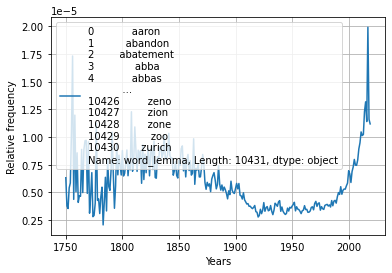

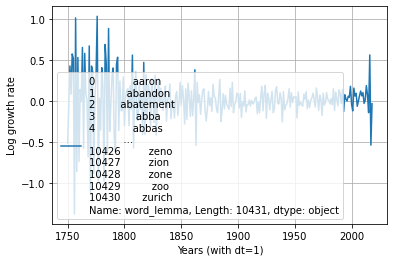

  0%|          | 3/10431 [00:02<2:39:24,  1.09it/s]

      word_lemma                                   wordorig  \
0          aaron                                 Aaron_NOUN   
1        abandon                               abandon_NOUN   
2      abatement              Abatement_NOUN abatement_NOUN   
3           abba                                  Abba_NOUN   
4          abbas                                 Abbas_NOUN   
...          ...                                        ...   
10426       zeno                                  Zeno_NOUN   
10427       zion                                  Zion_NOUN   
10428       zone  Zone_NOUN zone_NOUN Zones_NOUN zones_NOUN   
10429        zoo                                   zoo_NOUN   
10430     zurich                                Zurich_NOUN   

                                                 samples  
0      [217, 148, 102, 234, 234, 379, 492, 149, 444, ...  
1      [11, 13, 7, 15, 33, 12, 9, 4, 18, 12, 19, 12, ...  
2      [267, 436, 123, 164, 189, 210, 125, 252, 136, ...  
3      

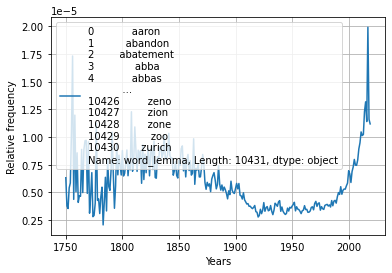

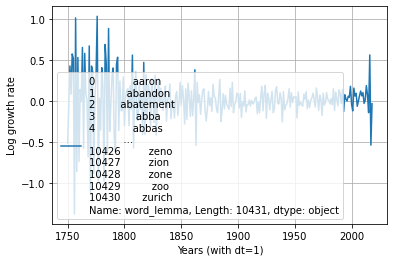

  0%|          | 4/10431 [00:03<2:39:50,  1.09it/s]

      word_lemma                                   wordorig  \
0          aaron                                 Aaron_NOUN   
1        abandon                               abandon_NOUN   
2      abatement              Abatement_NOUN abatement_NOUN   
3           abba                                  Abba_NOUN   
4          abbas                                 Abbas_NOUN   
...          ...                                        ...   
10426       zeno                                  Zeno_NOUN   
10427       zion                                  Zion_NOUN   
10428       zone  Zone_NOUN zone_NOUN Zones_NOUN zones_NOUN   
10429        zoo                                   zoo_NOUN   
10430     zurich                                Zurich_NOUN   

                                                 samples  
0      [217, 148, 102, 234, 234, 379, 492, 149, 444, ...  
1      [11, 13, 7, 15, 33, 12, 9, 4, 18, 12, 19, 12, ...  
2      [267, 436, 123, 164, 189, 210, 125, 252, 136, ...  
3      

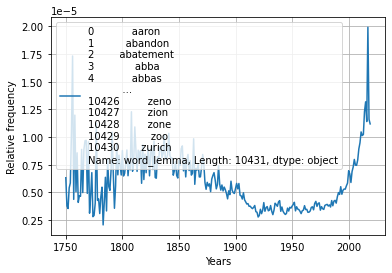

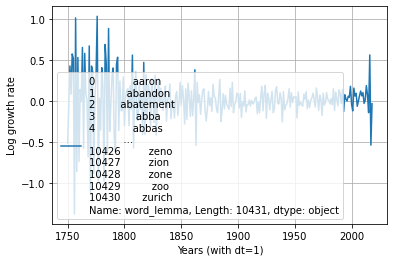

  0%|          | 5/10431 [00:04<2:34:12,  1.13it/s]

      word_lemma                                   wordorig  \
0          aaron                                 Aaron_NOUN   
1        abandon                               abandon_NOUN   
2      abatement              Abatement_NOUN abatement_NOUN   
3           abba                                  Abba_NOUN   
4          abbas                                 Abbas_NOUN   
...          ...                                        ...   
10426       zeno                                  Zeno_NOUN   
10427       zion                                  Zion_NOUN   
10428       zone  Zone_NOUN zone_NOUN Zones_NOUN zones_NOUN   
10429        zoo                                   zoo_NOUN   
10430     zurich                                Zurich_NOUN   

                                                 samples  
0      [217, 148, 102, 234, 234, 379, 492, 149, 444, ...  
1      [11, 13, 7, 15, 33, 12, 9, 4, 18, 12, 19, 12, ...  
2      [267, 436, 123, 164, 189, 210, 125, 252, 136, ...  
3      

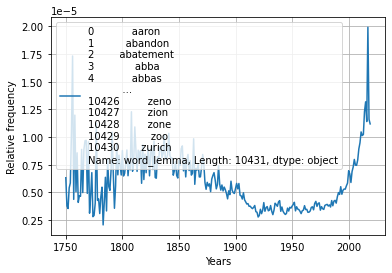

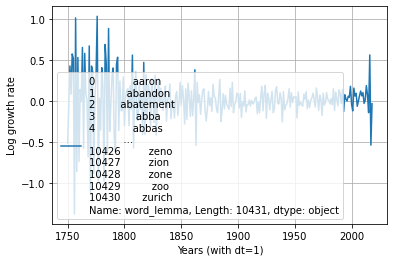

  0%|          | 6/10431 [00:05<2:37:19,  1.10it/s]

      word_lemma                                   wordorig  \
0          aaron                                 Aaron_NOUN   
1        abandon                               abandon_NOUN   
2      abatement              Abatement_NOUN abatement_NOUN   
3           abba                                  Abba_NOUN   
4          abbas                                 Abbas_NOUN   
...          ...                                        ...   
10426       zeno                                  Zeno_NOUN   
10427       zion                                  Zion_NOUN   
10428       zone  Zone_NOUN zone_NOUN Zones_NOUN zones_NOUN   
10429        zoo                                   zoo_NOUN   
10430     zurich                                Zurich_NOUN   

                                                 samples  
0      [217, 148, 102, 234, 234, 379, 492, 149, 444, ...  
1      [11, 13, 7, 15, 33, 12, 9, 4, 18, 12, 19, 12, ...  
2      [267, 436, 123, 164, 189, 210, 125, 252, 136, ...  
3      

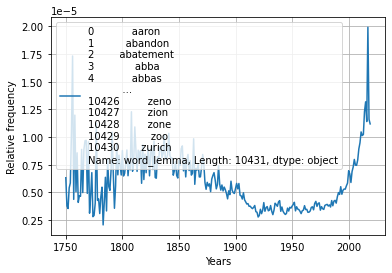

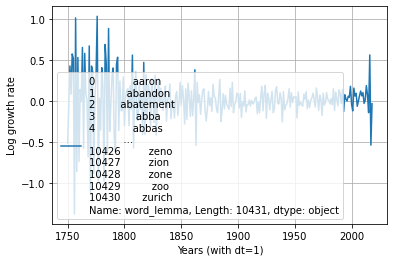

  0%|          | 7/10431 [00:06<2:41:01,  1.08it/s]

      word_lemma                                   wordorig  \
0          aaron                                 Aaron_NOUN   
1        abandon                               abandon_NOUN   
2      abatement              Abatement_NOUN abatement_NOUN   
3           abba                                  Abba_NOUN   
4          abbas                                 Abbas_NOUN   
...          ...                                        ...   
10426       zeno                                  Zeno_NOUN   
10427       zion                                  Zion_NOUN   
10428       zone  Zone_NOUN zone_NOUN Zones_NOUN zones_NOUN   
10429        zoo                                   zoo_NOUN   
10430     zurich                                Zurich_NOUN   

                                                 samples  
0      [217, 148, 102, 234, 234, 379, 492, 149, 444, ...  
1      [11, 13, 7, 15, 33, 12, 9, 4, 18, 12, 19, 12, ...  
2      [267, 436, 123, 164, 189, 210, 125, 252, 136, ...  
3      

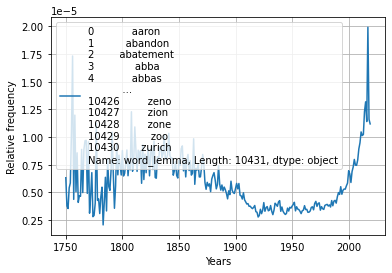

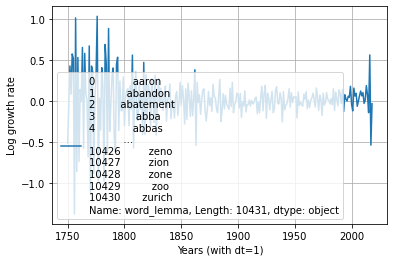

  0%|          | 8/10431 [00:08<3:17:37,  1.14s/it]

      word_lemma                                   wordorig  \
0          aaron                                 Aaron_NOUN   
1        abandon                               abandon_NOUN   
2      abatement              Abatement_NOUN abatement_NOUN   
3           abba                                  Abba_NOUN   
4          abbas                                 Abbas_NOUN   
...          ...                                        ...   
10426       zeno                                  Zeno_NOUN   
10427       zion                                  Zion_NOUN   
10428       zone  Zone_NOUN zone_NOUN Zones_NOUN zones_NOUN   
10429        zoo                                   zoo_NOUN   
10430     zurich                                Zurich_NOUN   

                                                 samples  
0      [217, 148, 102, 234, 234, 379, 492, 149, 444, ...  
1      [11, 13, 7, 15, 33, 12, 9, 4, 18, 12, 19, 12, ...  
2      [267, 436, 123, 164, 189, 210, 125, 252, 136, ...  
3      

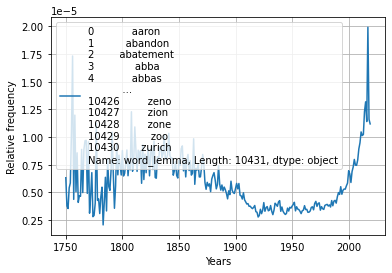

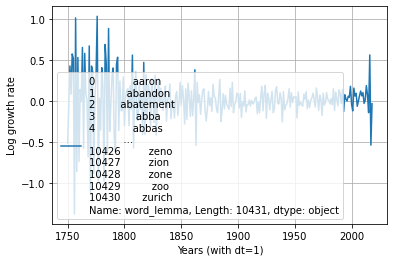

  0%|          | 9/10431 [00:09<3:20:26,  1.15s/it]

      word_lemma                                   wordorig  \
0          aaron                                 Aaron_NOUN   
1        abandon                               abandon_NOUN   
2      abatement              Abatement_NOUN abatement_NOUN   
3           abba                                  Abba_NOUN   
4          abbas                                 Abbas_NOUN   
...          ...                                        ...   
10426       zeno                                  Zeno_NOUN   
10427       zion                                  Zion_NOUN   
10428       zone  Zone_NOUN zone_NOUN Zones_NOUN zones_NOUN   
10429        zoo                                   zoo_NOUN   
10430     zurich                                Zurich_NOUN   

                                                 samples  
0      [217, 148, 102, 234, 234, 379, 492, 149, 444, ...  
1      [11, 13, 7, 15, 33, 12, 9, 4, 18, 12, 19, 12, ...  
2      [267, 436, 123, 164, 189, 210, 125, 252, 136, ...  
3      

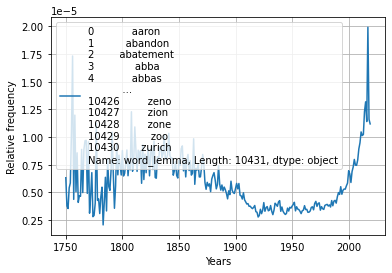

  0%|          | 9/10431 [00:21<6:51:02,  2.37s/it]


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [56]:

y_0 = np.array([])
y_f = np.array([])

for i in tqdm(range(len(data_singular))):
    word=data_singular['word_lemma']
    y_0i, y_fi = log_growth_rate(data_singular, word, samples_totales, years)

    y_0 = np.append(y_0i,y_0)
    y_f = np.append(y_fi,y_f)

In [ ]:
 #calculo significancia
def births_and_deaths(N_w):
    Delta_b =
    Delta_d = 